In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.cm as cm

import math

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from patsy import dmatrices, dmatrix, demo_data


%matplotlib inline

In [37]:
df = pd.read_csv("data/VHI_S_result.csv", encoding="shift-jis")

In [40]:
df.head()

,subject,condition,value
0,岩崎,8,1.3
1,岩崎,1,0.8
2,岩崎,11,0.6
3,岩崎,10,0.5
4,岩崎,7,1.0


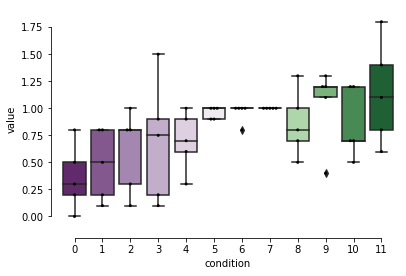

In [38]:
g = sns.boxplot(x='condition', y="value",data=df, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.swarmplot(x="condition", y="value", color="k", size=3, data=df)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


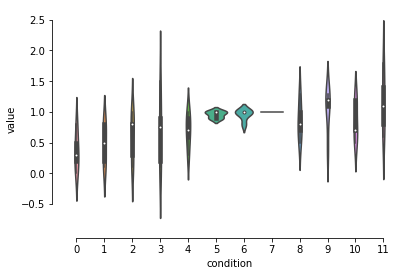

In [39]:
sns.violinplot(x='condition', y="value", data = df, split=True)
sns.despine(offset=10, trim=True)

conditionを面積に変換

In [7]:
condition_d = {0:20,1:20,2:20,3:20,4:40,5:40,6:40,7:40,8:60,9:60,10:60,11:60}
condition_l = {0:40,1:45,2:50,3:55,4:40,5:45,6:50,7:55,8:40,9:45,10:50,11:50}

In [8]:
df.loc[:,"l"] = df.loc[:,"condition"].map(condition_l)
df.loc[:,"d"] = df.loc[:,"condition"].map(condition_d)
df.head()

,subject,condition,value,l,d
0,âè,8,1.3,40,60
1,âè,1,0.8,45,20
2,âè,11,0.6,50,60
3,âè,10,0.5,50,60
4,âè,7,1.0,55,40


In [9]:
df.loc[:,"S"] = df.loc[:,"l"] * df.loc[:,"d"]
df.head()

,subject,condition,value,l,d,S
0,âè,8,1.3,40,60,2400
1,âè,1,0.8,45,20,900
2,âè,11,0.6,50,60,3000
3,âè,10,0.5,50,60,3000
4,âè,7,1.0,55,40,2200


In [ ]:
display(df)


[Text(0,0.5,'Magnitude value'), Text(0.5,0,'S (mm^2)')]

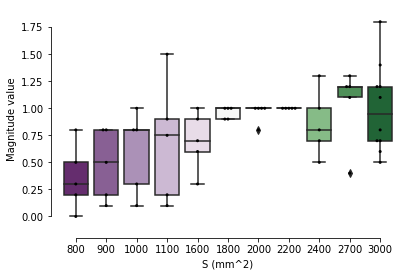

In [11]:
ax = sns.boxplot(x='S', y="value",data=df, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.swarmplot(x="S", y="value", color="k", size=3, data=df)
ax.set(xlabel='S (mm^2)', ylabel='Magnitude value')


べき乗則 (感覚値)=c*x^kでフィッティングしてみる

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


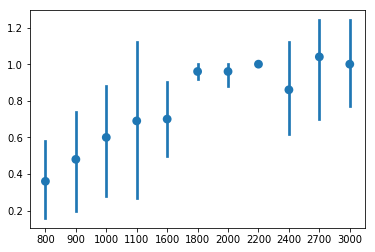

In [12]:
list_y = []
array_x = df["S"].values
array_y = df["value"].values

sns.pointplot(x=array_x, y=array_y, join=False)

In [13]:
def power_low(x,c,k):
    return c*(x**k)

In [14]:
param, cov = curve_fit(power_low, df["S"].values, df["value"].values)
print("c=",param[0])
print("k=",param[1])

c= 0.012215540895764453
k= 0.558884117745741


statsmodelでOLSでべき乗そくをフィッティング

In [15]:
data = df.loc[df["value"] != 0,:] #logとるので0を除く
formula = 'np.log(value) ~ np.log(S)'
results = smf.ols(formula, data=data).fit()

In [16]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(value)   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     22.31
Date:                Tue, 29 Jan 2019   Prob (F-statistic):           1.55e-05
Time:                        17:24:04   Log-Likelihood:                -49.380
No. Observations:                  59   AIC:                             102.8
Df Residuals:                      57   BIC:                             106.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.1287      1.224     -5.009      0.0

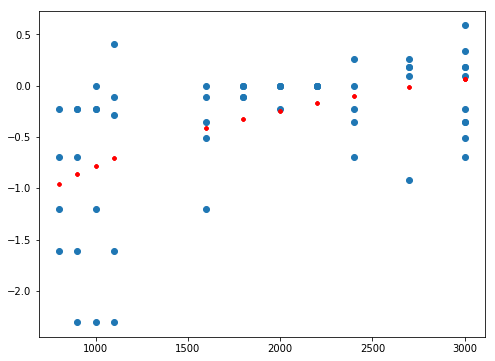

In [17]:
#yがlogスケールのプロット
x = data["S"]
y = data["value"]


ig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, np.log(y), 'o', label="data")
ax.plot(x, results.fittedvalues, 'r--.', label="OLS",linestyle='None')


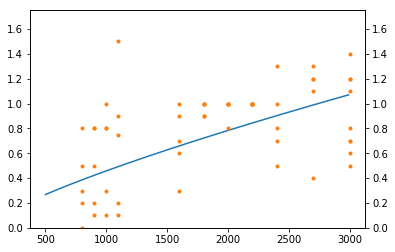

In [18]:
#ｙを元のスケールに戻してプロット
results.params
fig = plt.figure()
ax1 = fig.add_subplot(111)
list_y = []
axis_x = np.arange(500,3000,10)

for num in axis_x:
    list_y.append(math.e**results.params[0]*(num**results.params[1]) )


ln1=ax1.plot(axis_x, np.array(list_y).reshape(-1),'C0')
ax1.set_ylim(0,1.75)

ax2 = ax1.twinx()
ax2.set_ylim(0,1.75)
ln2=ax2.plot(array_x,array_y,'C1',marker=".",linestyle='None')

cv値を計算する

In [19]:
#方法1
data = df.loc[df["value"] != 0,:] #logとるので0を除く
data = data.reset_index()

kf_random = KFold(n_splits = 5,shuffle = True)
kf_random.get_n_splits(data)
print(kf_random)
for train_index, test_index in kf_random.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("train len", len(train_index), "test len", len(test_index))

KFold(n_splits=5, random_state=None, shuffle=True)
TRAIN: [ 1  3  4  5  7  8  9 10 13 14 15 16 17 18 19 20 21 23 24 25 26 27 28 29
 30 31 33 34 35 36 38 39 40 41 43 45 47 48 49 50 51 52 54 55 56 57 58] TEST: [ 0  2  6 11 12 22 32 37 42 44 46 53]
train len 47 test len 12
TRAIN: [ 0  1  2  4  5  6  7  8  9 11 12 13 14 16 18 19 20 21 22 23 24 25 27 29
 30 31 32 33 35 36 37 39 40 41 42 44 46 47 48 49 50 51 53 55 56 57 58] TEST: [ 3 10 15 17 26 28 34 38 43 45 52 54]
train len 47 test len 12
TRAIN: [ 0  1  2  3  6  7 10 11 12 13 14 15 16 17 18 20 21 22 24 25 26 27 28 29
 30 32 34 35 36 37 38 40 41 42 43 44 45 46 48 49 50 51 52 53 54 55 57] TEST: [ 4  5  8  9 19 23 31 33 39 47 56 58]
train len 47 test len 12
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 17 18 19 20 22 23 25 26 27 28
 30 31 32 33 34 35 37 38 39 42 43 44 45 46 47 48 52 53 54 55 56 57 58] TEST: [13 14 16 21 24 29 36 40 41 49 50 51]
train len 47 test len 12
TRAIN: [ 0  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 19 21 22 23 2

  # スティーヴンスのべき法則

(感覚量) = k * (刺激量)^a

Intercept   -6.177750
np.log(S)    0.778181
dtype: float64
rescaled intercept: 0.002075092122531431


FileNotFoundError: [Errno 2] No such file or directory: 'figure/figure1.png'

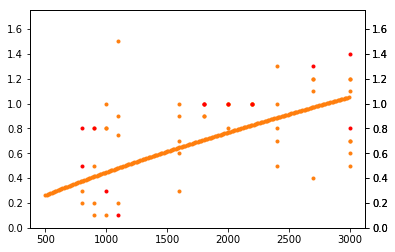

In [20]:
#indexで5Foldに分ける
cv_rand_results_steaven = []
cv_rand_preds_steaven = []
cv_rand_scores_rmse_steaven = []
cv_rand_scores_mae_steaven = []
cv_rand_train_scores_mae_steaven = []

i = 0
x = data.loc[:11,"S"]

formula = 'np.log(value) ~ np.log(S)'


for train_index, test_index in kf_random.split(data):
    
    y_pred = []
    train_pred = []
    
    i += 1
    data_train = data.loc[train_index,:]
    data_test = data.loc[test_index,:]
    
    #fitting
    
    results = smf.ols(formula, data=data_train).fit()
    cv_rand_results_steaven.append(results)
    
    
    #predict 元のスケールで
    
    test_x = data_test["S"].values
    train_x = data_train["S"].values
    for num in train_x:
        train_pred.append(math.e**results.params[0]*(num**results.params[1]) )
    
    for num in test_x:
        y_pred.append(math.e**results.params[0]*(num**results.params[1]) )
    
    cv_rand_preds_steaven.append(y_pred)
    
    y_train = data_train["value"].values
    y_test = data_test["value"].values
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_rand_scores_rmse_steaven.append(rmse)
    mae = mean_absolute_error(y_test, y_pred)
    cv_rand_scores_mae_steaven.append(mae)
    train_mae = mean_absolute_error(y_train, train_pred)
    cv_rand_train_scores_mae_steaven.append(train_mae)
    
    print(results.params)
    print("rescaled intercept:",np.exp(results.params[0]))
    #plot
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    axis_x = np.arange(500,3000,10)
    
    list_y =[]

    for num in axis_x:
        list_y.append(math.e**results.params[0]*(num**results.params[1]) )
        
    ##トレインデータ

    ax1.set_ylim(0,1.75)
    ln1=ax1.plot(data_train["S"],data_train["value"],'C1',marker=".",linestyle='None')
    
    ##べき関数
    
    ax3 = ax1.twinx()
    ax3.set_ylim(0,1.75)
    ln3=ax3.plot(axis_x,list_y,'C1',marker=".",linestyle='None')
    
    ##テストデータ
    
    ax4 = ax1.twinx()
    ax4.set_ylim(0,1.75)
    ln4=ax4.plot(data_test["S"],data_test["value"],'C1',marker=".",linestyle='None',color='red')
    
    plt.savefig('figure/figure' + str(i) + '.png')
    plt.show()

In [ ]:
print("cv_randでの平方二乗誤差")
print(cv_rand_scores_rmse_steaven)

In [ ]:
print("cv_randscore_rmseの平均")
print(np.array(cv_rand_scores_rmse_steaven).mean())

In [ ]:
print("cv_randでの絶対平均誤差")
print(cv_rand_scores_mae_steaven)

In [ ]:
print("cv_randscore_maeの平均")
print(np.array(cv_rand_scores_mae_steaven).mean())

In [ ]:
print("train_mae")
print(cv_rand_train_scores_mae_steaven)

# 一次関数でもcv値計算してみる

In [ ]:
#indexで5Foldに分ける
cv_rand_results = []
cv_rand_preds = []
cv_rand_scores_rmse = []
cv_rand_scores_mae = []
cv_rand_train_scores_mae = []



i = 0
x = data.loc[:11,"S"]

formula = 'value ~ S'


#一次式で回帰

for train_index, test_index in kf_random.split(data):
    
    y_pred = []
    
    i += 1
    data_train = data.loc[train_index,:]
    data_test = data.loc[test_index,:]
    
    #fitting
    
    results = smf.ols(formula, data=data_train).fit()
    cv_rand_results.append(results)
    
    cv_rand_train_scores_mae.append(np.abs(results.resid).mean())
    
    
    
    print(results.summary())
    
    #predict 元のスケールで
    test_x = data_test["S"].values
    y_pred = results.predict(data_test)    
    cv_rand_preds.append(y_pred)
    
    y_test = data_test["value"].values
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_rand_scores_rmse.append(rmse)
    mae = mean_absolute_error(y_test, y_pred)
    cv_rand_scores_mae.append(mae)
    
    print(results.params)
    
    #plot
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    axis_x = np.arange(500,3000,10)    
    axis_x = pd.DataFrame({"S":axis_x})

    list_y = results.predict(axis_x)
        
   ##トレインデータ
    
    ax1.set_ylim(0,1.75)
    ln1=ax1.plot(data_train["S"],data_train["value"],'C1',marker=".",linestyle='None')
    
    ##近似関数
    
    ax3 = ax1.twinx()
    ax3.set_ylim(0,1.75)
    ln3=ax3.plot(axis_x,list_y,'C1',marker=".",linestyle='None')
    
    ##テストデータ
    
    ax4 = ax1.twinx()
    ax4.set_ylim(0,1.75)
    ln4=ax4.plot(data_test["S"],data_test["value"],'C1',marker=".",linestyle='None',color='red')
    
    plt.savefig('figure/figure' + str(i) + '.png')
    plt.show()

In [ ]:
print("cv_randでの平方二乗誤差")
print(cv_rand_scores_rmse)

In [ ]:
print("cv_randscore_rmseの平均")
print(np.array(cv_rand_scores_rmse).mean())

In [ ]:
print("cv_randでの絶対平均誤差")
print(cv_rand_scores_mae)

In [ ]:
print("cv_randscore_maeの平均")
print(np.array(cv_rand_scores_mae).mean())

In [ ]:
print("train_mae")
print(cv_rand_train_scores_mae)

# フェヒナーの法則

（感覚量）＝ C*log(刺激量)

In [ ]:
#indexで5Foldに分ける
cv_rand_results_fef = []
cv_rand_preds_fef = []
cv_rand_scores_rmse_fef = []
cv_rand_scores_mae_fef = []
cv_rand_train_scores_mae_fef = []



i = 0
x = data.loc[:11,"S"]

formula = 'value ~ np.log(S)'


#一次式で回帰

for train_index, test_index in kf_random.split(data):
    
    y_pred = []
    
    i += 1
    data_train = data.loc[train_index,:]
    data_test = data.loc[test_index,:]
    
    #fitting
    
    results = smf.ols(formula, data=data_train).fit()
    cv_rand_results_fef.append(results)
    
    cv_rand_train_scores_mae_fef.append(np.abs(results.resid).mean())
    
    
    
    print(results.summary())
    
    #predict 元のスケールで
    test_x = data_test["S"].values
    y_pred = results.predict(data_test)    
    cv_rand_preds.append(y_pred)
    
    y_test = data_test["value"].values
    
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    cv_rand_scores_rmse_fef.append(rmse)
    mae = mean_absolute_error(y_test, y_pred)
    cv_rand_scores_mae_fef.append(mae)
    
    print(results.params)
    
    #plot
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    axis_x = np.arange(500,3000,10)    
    axis_x = pd.DataFrame({"S":axis_x})

    list_y = results.predict(axis_x)
        
   ##トレインデータ
    
    ax1.set_ylim(0,1.75)
    ln1=ax1.plot(data_train["S"],data_train["value"],'C1',marker=".",linestyle='None')
    
    ##近似関数
    
    ax3 = ax1.twinx()
    ax3.set_ylim(0,1.75)
    ln3=ax3.plot(axis_x,list_y,'C1',marker=".",linestyle='None')
    
    ##テストデータ
    
    ax4 = ax1.twinx()
    ax4.set_ylim(0,1.75)
    ln4=ax4.plot(data_test["S"],data_test["value"],'C1',marker=".",linestyle='None',color='red')
    
    plt.savefig('figure/figure' + str(i) + '.png')
    plt.show()

In [ ]:
print("cv_randでの平方二乗誤差")
print(cv_rand_scores_rmse_fef)

In [ ]:
print("cv_randscore_rmseの平均")
print(np.array(cv_rand_scores_rmse_fef).mean())

In [ ]:
print("train_mae")
print(cv_rand_train_scores_mae_fef)

In [ ]:
print("train_maeの平均")
print(np.array(cv_rand_train_scores_mae_fef).mean())

# CV値の箱ひげ図

In [ ]:
import plotly
plotly.offline.init_notebook_mode(connected=False)

In [ ]:
trace1 =  plotly.graph_objs.Box(
    y= cv_rand_scores_mae,
    boxmean=True,
    name="Linear")

trace_steaven =  plotly.graph_objs.Box(
    y= cv_rand_scores_mae_steaven,
    boxmean=True,
    name="Steven")

trace_Fechner =  plotly.graph_objs.Box(
    y= cv_rand_scores_mae_fef,
    boxmean=True,
    name="Fechner")

In [ ]:
layout = plotly.graph_objs.Layout(
    title="Test score(MAE)",
    xaxis={"title":"Model"},
    yaxis={"title":"CV  score (test)"}
)

In [ ]:
data_plot = [trace1, trace_steaven, trace_Fechner]
fig = plotly.graph_objs.Figure(data=data_plot, layout=layout)
plotly.offline.iplot(fig)

In [ ]:
trace1 =  plotly.graph_objs.Box(
    y= cv_rand_train_scores_mae,
    boxmean=True,
    name="Linear")

trace_steaven =  plotly.graph_objs.Box(
    y= cv_rand_train_scores_mae_steaven,
    boxmean=True,
    name="Steven")

trace_fechner =  plotly.graph_objs.Box(
    y= cv_rand_train_scores_mae_fef,
    boxmean=True,
    name="Fechner")

In [ ]:
layout = plotly.graph_objs.Layout(
    title="Train score(MAE)",
    xaxis={"title":"Model"},
    yaxis={"title":"CV  score (train)"}
)

In [ ]:
data_plot = [trace1, trace_steaven, trace_fechner]
fig = plotly.graph_objs.Figure(data=data_plot, layout=layout)
plotly.offline.iplot(fig)